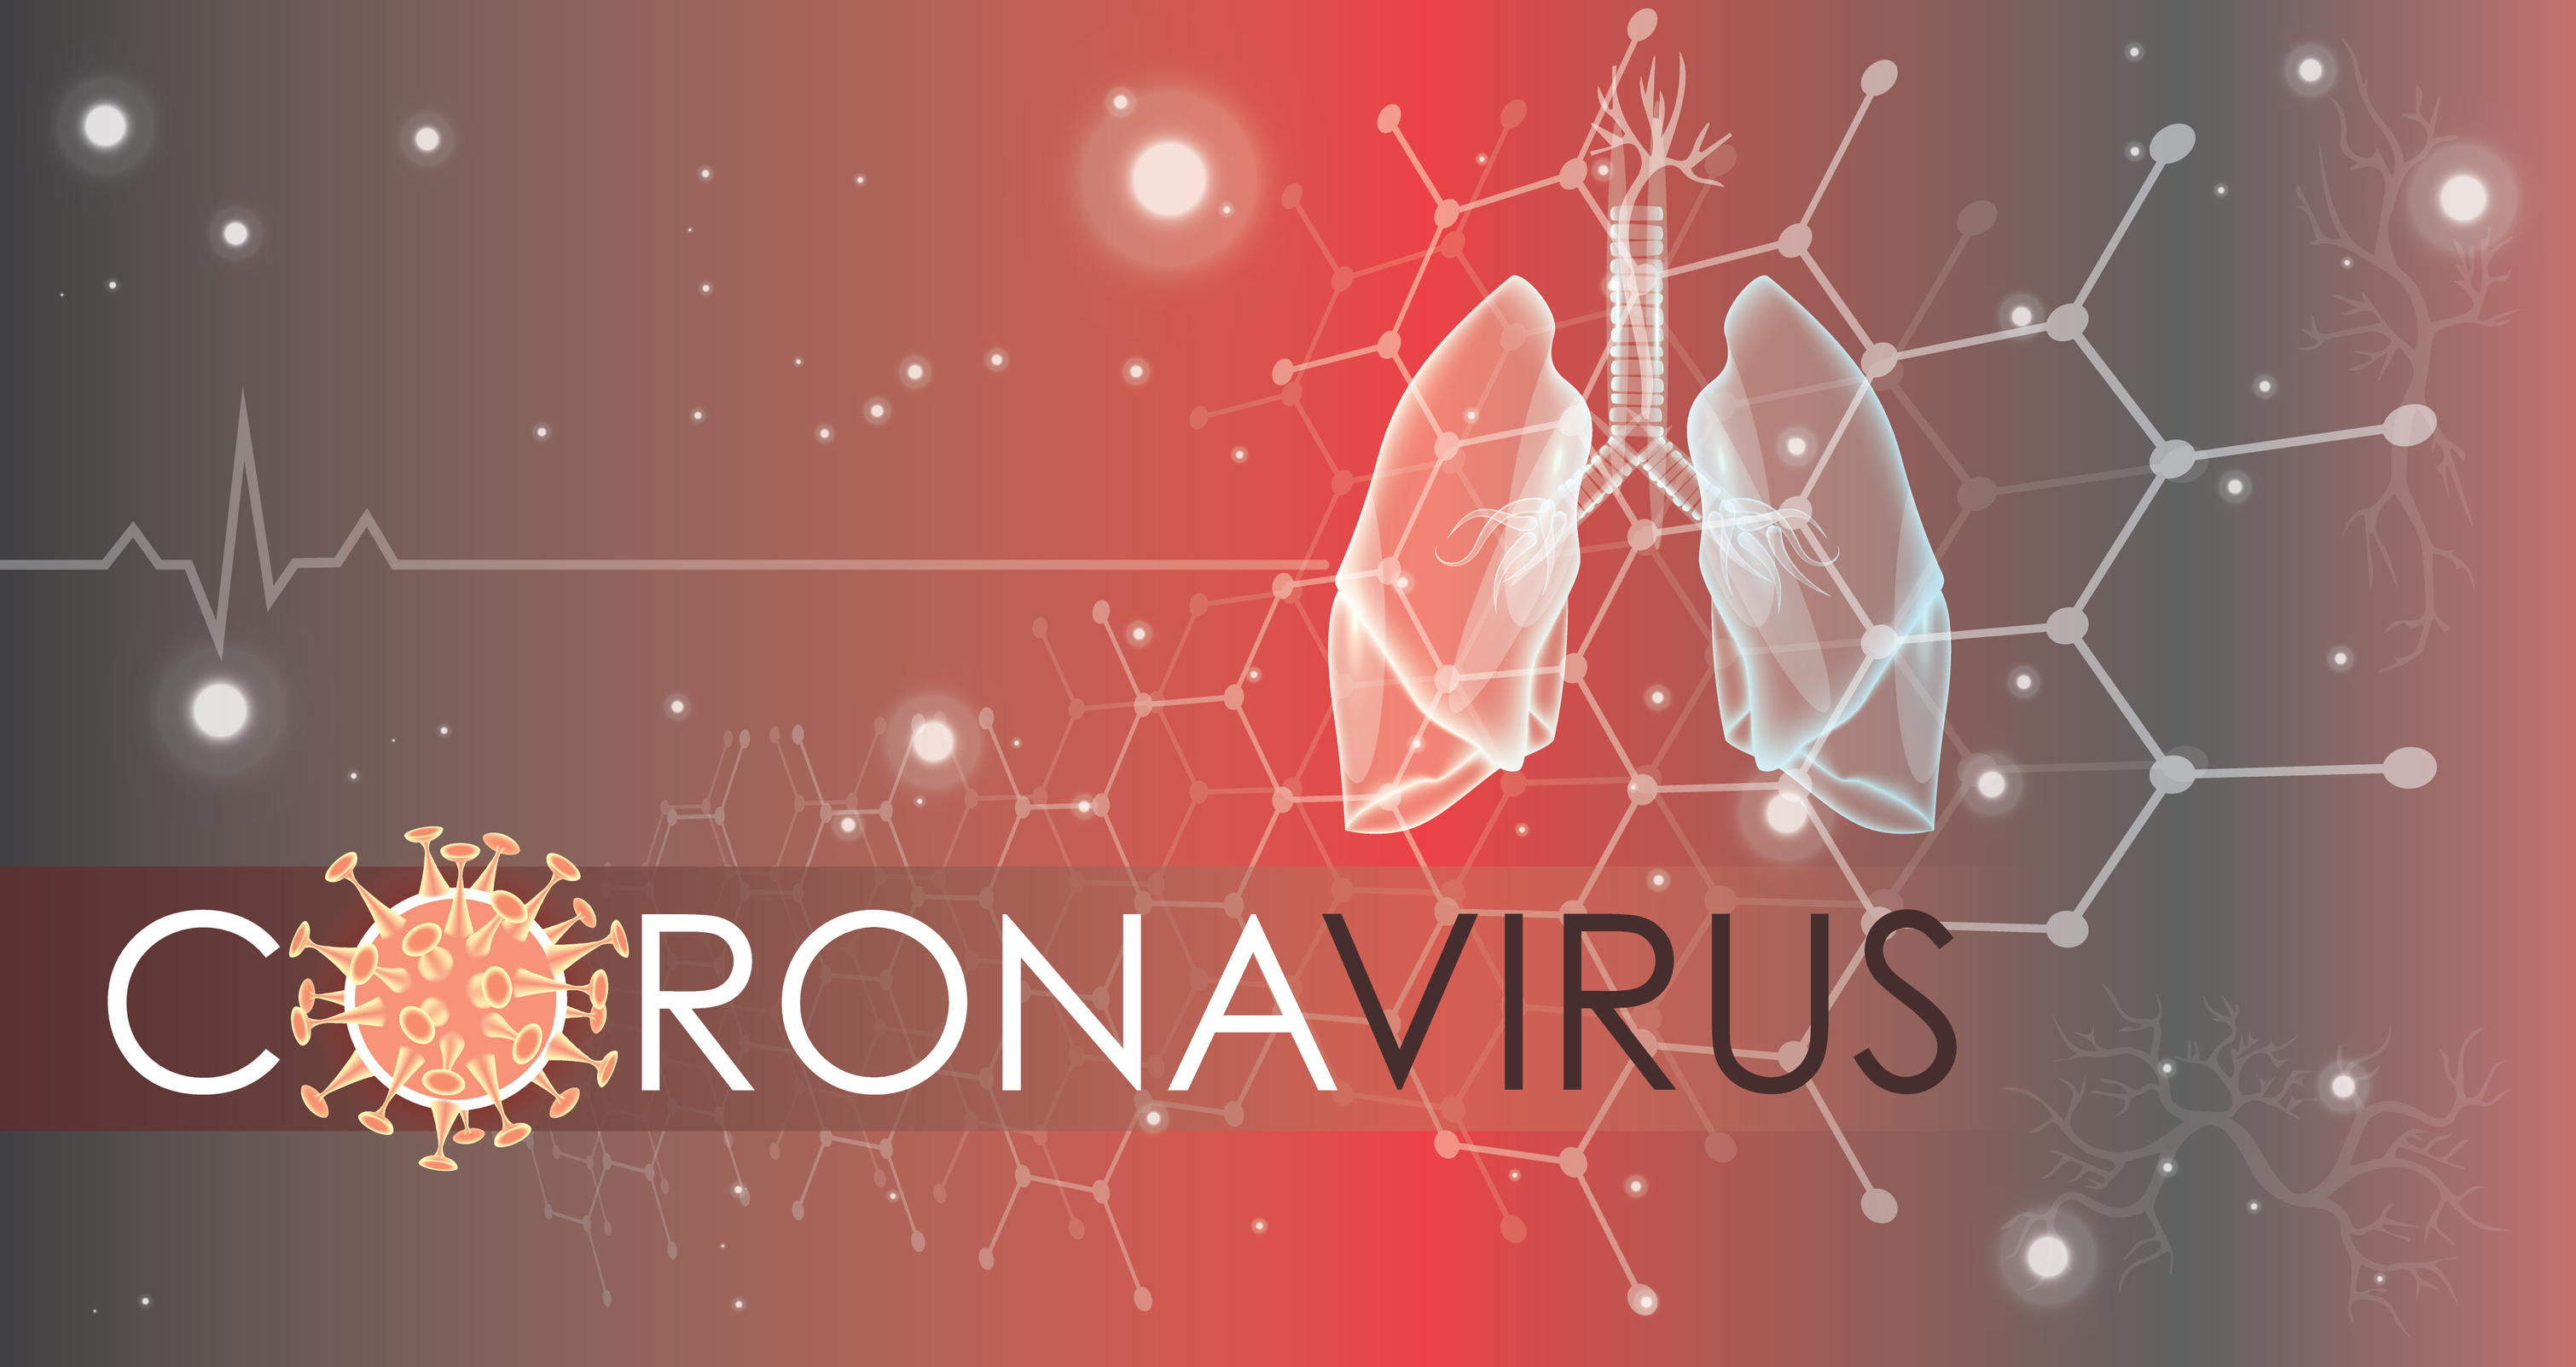

# Covid-19 Analysis and Visualization

In [1]:
import requests  
import json
import pprint   
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly as py
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

url = 'https://api.inews.qq.com/newsqa/v1/automation/modules/list?modules=FAutoCountryConfirmAdd,WomWorld,WomAboard&=%d' % int(time.time() *1000)
urlC = 'https://api.inews.qq.com/newsqa/v1/query/inner/publish/modules/list?modules=statisGradeCityDetail,diseaseh5Shelf&=%d' % int(time.time() * 1000)


# Scraping data from web page 

In [2]:
response = requests.get(url=url)
web_data = response.json()
world_data = web_data['data']['WomAboard']
    #pprint.pprint(world_data)

world_covid = []

for i in world_data:
    world_dict = {}
    world_dict['continent'] = i['continent']
    world_dict['country'] = i['name']
    world_dict['confirm'] = i['confirm']
    world_dict['active'] = i['nowConfirm']
    world_dict['newcases'] = i['confirmAdd']
    world_dict['dead'] = i['dead']
    world_dict['heal'] = i['heal']
    world_covid.append(world_dict)


In [3]:
world = pd.DataFrame(world_covid)
world[world['country']=='中国'] # to search for China's data
world.head()

,continent,country,confirm,active,newcases,dead,heal
0,北美洲,美国,86522561,2904439,19504,1033591,82584531
1,亚洲,印度,43181335,25782,3255,524701,42630852
2,南美洲,巴西,31153765,423027,696,667056,30063682
3,欧洲,法国,29641606,452024,20542,148464,29041118
4,欧洲,德国,26540852,846604,1010,139748,25554500


# Scraping China's data from web page

In [3]:
response_china = requests.get(url = urlC).json()
china_status = response_china['data']['diseaseh5Shelf']['areaTree'][0]['children']
#pprint.pprint(china_data)

china_covid = []
for i in china_status:
    china_dict ={}
    china_dict['province'] = i['name']
    china_dict['totalcase'] = i['total']['confirm']
    china_dict['active'] = i['total']['nowConfirm']
    china_dict['newcases'] = i['today']['confirm']
    china_dict['dead'] = i['total']['dead']
    china_dict['heal'] = i['total']['heal']
    china_covid.append(china_dict)
    

In [5]:
china = pd.DataFrame(china_covid)
china.head()

,province,totalcase,active,newcases,dead,heal
0,台湾,2404871,2388190,62077,2939,13742
1,香港,332721,260825,56,9386,62510
2,北京,3432,248,5,9,3175
3,天津,1977,137,1,3,1837
4,吉林,40293,131,0,5,40157


# Incorporate 2 set of data and generate dataframe

In [4]:
world = pd.DataFrame(world_covid)

china_status = response_china['data']['diseaseh5Shelf']['areaTree'][0]
confirm = china_status['total']['confirm']
active = china_status['total']['nowConfirm']
newcases = china_status['today']['confirm']
dead = china_status['total']['dead']
heal = china_status['total']['heal']

# To incorporate china's data into world's data
worldwide = world.append(
{
    'continent' : "亚洲",
    'country' : "中国",
    'confirm' : confirm,
    'active' : active,
    'newcases' : newcases,
    'dead' : dead,
    'heal' : heal

}, ignore_index = True)

worldwide.loc[worldwide['country'] == "中国"]

#To calculate deaths and recovered ratio
worldwide['Deaths ratio'] = (worldwide['dead'] / worldwide['confirm']*100).map('{:,.2f}%'.format)
worldwide['Recovered ratio'] = (worldwide['heal'] / worldwide['confirm']*100).map('{:,.2f}%'.format)
worldwide.rename(columns={'confirm':"Confirmed",'active':"Active",'newcases':"Newcases",'dead':"Deaths",'heal':"Recovered"},
                 inplace=True)
#worldwide.columns

country_name = pd.read_csv('D:\Program Files\PyCharm Project\Hello Python\world_map.csv', encoding='gbk')
pandemic = pd.merge(worldwide, country_name, left_on="country", right_on="国家", how="inner")
order = ['Continents','Country','Confirmed','Active','Newcases','Deaths','Recovered','Deaths ratio','Recovered ratio','国家','七大洲']
pandemic = pandemic[order]
pandemic.sort_values(by='Confirmed', ascending = False).head(10)

#pandemic[pandemic['Country']=='China']

,Continents,Country,Confirmed,Active,Newcases,Deaths,Recovered,Deaths ratio,Recovered ratio,国家,七大洲
0,North America,United States,86988671,3127641,96848,1035031,82825999,1.19%,95.21%,美国,北美洲
1,Asia,India,43197522,32498,7240,524723,42640301,1.21%,98.71%,印度,亚洲
2,South America,Brazil,31315777,492690,49614,667701,30155386,2.13%,96.29%,巴西,南美洲
3,Europe,France,29713219,421996,53802,148668,29142555,0.50%,98.08%,法国,欧洲
4,Europe,Germany,26652380,753432,42047,139948,25759000,0.53%,96.65%,德国,欧洲
5,Europe,United Kingdom,22363067,176855,13884,179083,22007129,0.80%,98.41%,英国,欧洲
6,Europe,Russia,18362105,204744,3646,379736,17777625,2.07%,96.82%,俄罗斯,欧洲
7,Asia,Korea,18188200,249795,13320,24305,17914100,0.13%,98.49%,韩国,亚洲
8,Europe,Italy,17566061,628995,22361,167169,16769897,0.95%,95.47%,意大利,欧洲
9,Asia,Turkey,15072747,2526,0,98965,14971256,0.66%,99.33%,土耳其,亚洲


# To generate numbers base on continents

In [5]:
condition_list = ['Confirmed','Active','Newcases','Deaths','Recovered']
#world_pandemic.applymap(lambda x:format(int(x),','))
#apply(lambda x: format(x,'.2%'))
world_pandemic = pandemic.groupby('Continents')[condition_list].sum() #.sort_values(by='confirm', ascending = False)
world_pandemic.loc['World cases'] = world_pandemic.apply(lambda x: x.sum())

world_pandemic['Deaths ratio'] = (world_pandemic['Deaths'] / world_pandemic['Confirmed']).apply(lambda x: format(x,'.2%'))
world_pandemic['Recovered ratio'] = (world_pandemic['Recovered'] / world_pandemic['Confirmed']).apply(lambda x: format(x,'.2%'))
continents_df = world_pandemic.reset_index()
continents_df

,Continents,Confirmed,Active,Newcases,Deaths,Recovered,Deaths ratio,Recovered ratio
0,Africa,11466748,1525106,4587,250939,9690703,2.19%,84.51%
1,Asia,149836314,5466868,133797,1402977,142966469,0.94%,95.42%
2,Europe,197133354,12916266,174523,1819446,182397642,0.92%,92.53%
3,North America,101959883,4259298,110938,1470970,96229615,1.44%,94.38%
4,Oceania,8861000,309878,40343,11203,8539919,0.13%,96.38%
5,South America,58197372,1959773,61650,1300316,54937283,2.23%,94.40%
6,World cases,527454671,26437189,525838,6255851,494761631,1.19%,93.80%


# To generate numbers divided by conditions

In [6]:
df = continents_df.transpose().reset_index()
df1 = df.rename(columns=df.iloc[0]).loc[1:]
df_con = df1.rename(columns={'Continents':'Categories'})
df_con[:5]

#df_con.columns


,Categories,Africa,Asia,Europe,North America,Oceania,South America,World cases
1,Confirmed,11466748,149836314,197133354,101959883,8861000,58197372,527454671
2,Active,1525106,5466868,12916266,4259298,309878,1959773,26437189
3,Newcases,4587,133797,174523,110938,40343,61650,525838
4,Deaths,250939,1402977,1819446,1470970,11203,1300316,6255851
5,Recovered,9690703,142966469,182397642,96229615,8539919,54937283,494761631


# Data Visualization

In [7]:
continents = continents_df[:6]

fig = px.scatter(continents.sort_values(by='Confirmed', ascending = False), x='Continents', y='Confirmed', color='Confirmed', text='Confirmed',
           color_continuous_scale='rainbow',size='Confirmed', size_max=80, hover_data=['Confirmed', 'Continents'],
                labels={'Confirmed':"Total Confirmed Cases"})

fig.update_traces(textposition='top center', textfont_size=14, textfont_family="Arial Black", texttemplate='%{text:,.2s}')
fig = fig.update_layout(height=600, width=1000, title="Total confirmed cases in Covid-19 of affected continents")

fig.show()

# The scatter above illustrates the numbers of confirmed cases of Covid-19 among 7 continents in the world. The scatter highlights that Europe is the worst affected continent compare to others as it reach to total 200 million confirmed cases. Asia is the second worst of affected continents it has 150 million confirmed cases; North Ameirica rank to the thrid and the fourth goes to South America followed by Africa and Oceania.
# As of May 2022, Over 520 million confirmed cases have been reported globally. This is not a bright sign as it can tell the pandemic has impacted almost every corner of life.This may probably due to an opportunity to stop the spread of the virus during its early stages was missed and it caused serious consequences for many countries such as causing economies to stall, stretching healthcare systems to the limit and governments have been forced to implement harsh restrictions on human activity to control the spread of the virus.


In [8]:
colors = {'Recovered':'lightskyblue','Active':'darkorange', 'Deaths':'grey', 'Newcases':'midnightblue'}
labels = df_con[1:5]['Categories'].values

fig = px.pie(df_con[1:5], values='World cases', names=labels, color='Categories', 
             title='The Ratio of Situation of Covid-19', color_discrete_map= colors)

fig.update_traces(textposition='auto', textfont_color="black", textinfo='percent+label', insidetextorientation='radial',
                 textfont_size=14, textfont_family="Arial Black")

fig.update_layout(legend_title="Categories")

fig.show()


In [9]:
colors = {'Confirmed': 'maroon','Recovered':'lightskyblue', 'Active':'darkorange', 'Deaths':'gray', 'Newcases':'midnightblue'}
Continents = ['Europe', 'Asia', 'North America', 'South America', 'Africa', 'Oceania']
label = {'World cases': "Total No.of Cases"}

fig = px.bar(df_con[:5], x="World cases", y="Categories", orientation='h', labels=label, hover_data=Continents,
             color='Categories', text='World cases', color_discrete_map= colors)

fig.update_traces(textfont_family="Arial Black", textfont_size=14, textfont_color="white", textposition='auto',
                 texttemplate='%{text:,.3s}')

fig = fig.update_layout(template='plotly_dark', height=600, width=1000, title='The Global Situation of Covid-19',
                       yaxis_categoryorder = 'total ascending')
fig.show()


# Two chart above Pie and Bar indicate the situation of Covid-19 throughout the world. The Pie chart is about the ratio of Covid-19 situation whereas the Bar chart is showing the total number of cases. Both charts are divide into 5 categories; confirmed, active, newcases, deaths and recovered cases.
# According to the charts, out of over 525 mil confirmed cases reported globaly, over 480 million recovered cases have been reported which is 92% cases have been recovered from the pandemic.
# 6.8% which is 36 million cases are still active and over 6 million cases which 1.2% people have been reported deaths. It can be seen from information that active and deaths cases reported are less than half numbers compare to recovered cases.
# It is clear that the world are getting recovered from pandemic of Covid-19. This may due to goverments around the world have been made a great efforts to emphasize on pandamic prevention and medical attention.
# Also, many countries and societies are dedicating to furthering the vaccination ever since numerous vaccines begin their roll out in countries across the world.

In [10]:
colors = {'Europe': 'firebrick','Asia':'midnightblue', 'North America':'yellow', 'South America':'seagreen', 'Africa':'plum','Oceania':'darkorange'}
fig = make_subplots(rows=1, cols=2, shared_xaxes=False, shared_yaxes=False, specs=[[{"type": "domain"}, {"type": "domain"}]],)

fig_m = px.treemap(pandemic, path=['Continents','Country','Confirmed'], values='Confirmed', 
                   hover_data=['Active'], color='Continents', color_discrete_map= colors)

fig_s = px.sunburst(pandemic, path=['Continents','Country'], values='Confirmed',
                  color='Continents', hover_data=['Active'], color_discrete_map= colors)

fig.add_trace(fig_m['data'][0], row=1, col=1)
fig.add_trace(fig_s['data'][0], row=1, col=2)

fig = fig.update_layout(height=600, width=1000, title='The Confirmed cases of Covid-19 Throughout the World')
                       

fig.show()


# The diagram above describe the confirmed cases of Covid-19 of affected continents and countries around the world.
# It clearly shows that Europe is the worst affected continents and France is the highest confirmed cases in Europe which has 29 million follow by Germany and UK both countries have 26 million and 22 million total confrimed cases respectively. 
# Asia is the second worst affected continent and India is the top higher confirmed cases which is 43 million cases and Korea is the second higher which is 17 million confirmed cases.
# The thrid goes to North America follow by South America. United States has a significant amount of total confirmed cases not only in North America but of all country, it has total 85 million confirmed cases. Brazil has 31 million confirmed cases the majority affected country in South America.
# In Oceania, Australia has the most confirmed cases. This makes sense as Australia is the largest country in this continent.

In [11]:
continents = continents_df[:6]['Continents']

fig = make_subplots(rows=2, cols=2, subplot_titles=('Confirmed cases','Active cases','Death cases','Recovered Cases',))

fig.add_trace(go.Bar(name='Confirmed cases', x=continents, y=continents_df['Confirmed'], 
                     marker=dict(color="maroon"), text=continents_df['Confirmed']), 1, 1)

fig.add_trace(go.Bar(name='Active cases', x=continents, y=continents_df['Active'], 
                     marker=dict(color="darkorange"), text=continents_df['Active']), 1, 2)


fig.add_trace(go.Bar(name='Death cases', x=continents, y=continents_df['Deaths'], 
                     marker=dict(color="gray"), text=continents_df['Deaths']), 2, 1)

fig.add_trace(go.Bar(name='Recovered cases', x=continents, y=continents_df['Recovered'],
                     marker=dict(color="lightskyblue"),text=continents_df['Recovered']), 2, 2)

fig.update_traces(textposition='auto', textfont_size=14, textfont_family="Arial Black", textfont_color="white", 
                  texttemplate='%{text:,.2s}')

fig.update_layout(template='plotly_dark', height=980, width=1000, showlegend=False, title='The Situation of Covid-19 by Continents')


fig.update_xaxes(row=1, col=1, title='Continents')
fig.update_xaxes(row=1, col=2, title='Continents')
fig.update_xaxes(row=2, col=1, title='Total Cases')
fig.update_xaxes(row=2, col=2, title='Total Cases')

fig.update_yaxes(row=1, col=1, title='Total Cases')
fig.update_yaxes(row=1, col=2, title='Total Cases')
fig.update_yaxes(row=2, col=1, title='Continents')
fig.update_yaxes(row=2, col=2, title='Continents')

fig.show()


# The 4 bar charts above tell the situation of Covid-19 among continents with divided into 4 conditions, they are total number of confirmed cases, active cases, death cases and recovered cases.
# Although Europe countries have the most confirmed cases, but they also have the higher recovered cases compare to other continents. This situation can tell that a tremendous medical assistance has plunged into Europe countries. 
# Asian countries considered more successful in curbing the virus spread, it can tells from the charts above that although Asia is the second higher of confirmed cases, however Asia also the second higher recovered continent and the numbers of active and deaths cases are less than Europe and North America not to mention that Asia is the largest population in the world. 
# The pandemic prevention measures in North America and South America are relatively unfavorable compare to Asia, this may due to many countires are easing their restriction precaution to curb the spread of virus.
# Total cases in Oceania with 4 conditions are relatively low compare to other continents due to less population in this area.

In [12]:
from plotly.subplots import make_subplots

grey, burgundy, peach, blue = '#393e46', '#8C001A', '#EAC117', '#99a9ff'

fig_c = px.bar(pandemic.sort_values(by='Confirmed', ascending = False).head(10), x='Confirmed', y='Country',
             labels={'Confirmed': "Confirmed Cases"}, text='Confirmed', hover_data=['Country','Continents'],
               color_discrete_sequence=[burgundy])

fig_a = px.bar(pandemic.sort_values(by='Active', ascending = False).head(10), x='Active', y='Country',
             labels={'Active': "Active Cases"}, text='Active', hover_data=['Country','Continents'],color_discrete_sequence=[peach])

fig_d = px.bar(pandemic.sort_values(by='Deaths', ascending = False).head(10), x='Deaths', y='Country',
             labels={'Deaths': "Deaths Cases"}, text='Deaths', hover_data=['Country','Continents'], color_discrete_sequence=[grey])

fig_r = px.bar(pandemic.sort_values(by='Recovered', ascending = False).head(10), x='Recovered', y='Country',
             labels={'Recovered': "Recovered Cases"}, text='Recovered', hover_data=['Country','Continents'], color_discrete_sequence=[blue])

fig = make_subplots(rows=2, cols=2, shared_xaxes=False, horizontal_spacing=0.14, vertical_spacing=0.1, 
                    subplot_titles=('Confirmed Cases','Active Cases','Deaths cases','Recovered Cases'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_a['data'][0], row=1, col=2)
fig.add_trace(fig_d['data'][0], row=2, col=1)
fig.add_trace(fig_r['data'][0], row=2, col=2)



fig.update_traces(textposition='auto', textfont_size=14, textfont_family="Arial", textfont_color="white", 
                  texttemplate='%{text:,.2s}')

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_yaxes(row=2, col=1, autorange='reversed')
fig.update_yaxes(row=2, col=2, autorange='reversed')

fig.update_layout(template='plotly_dark', height=980, width=1000, title='The Situation of Covid-19 by Top 10 Countries') 
# yaxis_categoryorder = 'total ascending'

fig.show()

# The diagram above give information of the top 10 affected countries in divided into 4 conditions of confirmed, active, death and recoverd cases in Covid-19 pandemic.
# According to charts above, United State, India and Brazil are most concentration  of Covid-19 in confirmed and death cases but they also have enormous recovered. This may be due to they had plenty of case to start off with.
# Ukraine has climb up to 4.9 million active cases the highest of all country recently, this may due to people living in Ukraine are suffering from depression, food and financial insecurity since Russia started its war with Ukraine at the end of February. People who are concerned about residence and food security or household finances may not be able to take the same pandemic precautions as those with stable condition and good financial security.These concerns can obstruct efforts to stop the spread of  Covid-19. 


In [13]:
fig = px.choropleth(pandemic, locations="Country", locationmode= "country names",
                    color="Confirmed", title="Covid-19 Situation In The World",height=550, width=1000,
                    hover_data=["Country","Continents","Recovered","Deaths","Active"], 
                    color_continuous_scale=px.colors.sequential.YlOrRd)
fig.show()


In [14]:
from pyecharts.charts import Map,Geo
from pyecharts import options as opts
from pyecharts.globals import GeoType,RenderType

global_list = list(zip(pandemic['Country'],pandemic['Confirmed']))
map = Map(opts.InitOpts(width='1100px',height='800px')).add(series_name = "World Pandemic Situation",
               data_pair = global_list,
               maptype = "world",
               #name_map=english_map, 
               is_map_symbol_show=False)

map.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map.set_global_opts(title_opts = opts.TitleOpts(title="Covid-19 Confirmed Cases Thourghout The World"),
                   visualmap_opts=opts.VisualMapOpts(is_piecewise=True,
                                                      pieces=[{
                                                          "min": 10000000,
                                                          "label": '>10000000',
                                                          "color": "#940808"}, {
                                                          "min": 1000000,
                                                         "max": 9999999,
                                                         "label": '1000000-9999999',
                                                         "color": "#d20404"},{
                                                          "min": 100000,
                                                          "max": 999999,
                                                          "label": '100000-999999',
                                                          "color": "#ff6700"},{
                                                          "min": 10000,
                                                          "max": 99999,
                                                          "label": '10000-99999',
                                                          "color": "#fdff00"}, {
                                                          "min": 1000,
                                                          "max": 9999,
                                                          "label": '1000-9999',
                                                          "color": "#b0ff00"}, {
                                                          "min": 0,
                                                          "max": 999,
                                                          "label": '0-999',
                                                          "color": "#b1d6ec"}
                                                            ]))
map.render_notebook()

# map.render('world pandemic.html')